In [4]:
cd ../..

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans


In [5]:
import os
import numpy as np
import pandas as pd
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, Conv1DTranspose, MaxPool1D, GlobalMaxPool1D, Flatten, Dropout, LeakyReLU, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from gans.utils import create_gan
from utils.windowing import windowing_dataframe, transform_windows_df
from utils.preprocess import filter_by_activity_index, calc_consultant
from utils.utils import check_dir_creation
from utils.plotting import plot_n_heatmaps, plot_n_lineplots
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def create_discriminator(input_shape):
    discriminator = Sequential()
    discriminator.add(Conv1D(8, kernel_size=5, activation='relu', input_shape=input_shape))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.summary()
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, clipvalue=1.0, decay=1e-8), metrics=['accuracy'])
    return discriminator

In [7]:
def create_generator(latent_dim, kernel_num, kernel_size, small=True):
    if small:
        generator = Sequential()
        generator.add(Dense(125 * 3, kernel_initializer='he_uniform', input_shape=(latent_dim,)))
        generator.add(LeakyReLU())
        generator.add(BatchNormalization())
        generator.add(Dropout(0.25))
        generator.add(Reshape((125, 3)))

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU())
        generator.add(Dropout(0.25))
        generator.add(BatchNormalization())

        generator.add(Conv1DTranspose(kernel_num, kernel_size=4, strides=2, padding='same'))
        generator.add(LeakyReLU())
        generator.add(Dropout(0.25))
        generator.add(BatchNormalization())

        generator.add(Conv1D(3, kernel_size=kernel_size, padding='same', kernel_initializer='he_uniform', activation='tanh'))
    else:
        generator = Sequential()
        generator.add(Dense(125 * 3, kernel_initializer='he_uniform', input_shape=(latent_dim,)))
        generator.add(LeakyReLU())
        generator.add(BatchNormalization())
        generator.add(Reshape((125, 3)))

        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU())
        generator.add(BatchNormalization())

        generator.add(Conv1D(kernel_num, kernel_size=5, kernel_initializer='he_uniform', padding='same'))#
        generator.add(LeakyReLU()) #
        generator.add(BatchNormalization())
        
        generator.add(Conv1DTranspose(kernel_num, kernel_size=4, strides=2, padding='same'))
        generator.add(LeakyReLU())
        generator.add(BatchNormalization())
        
        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU()) #
        generator.add(BatchNormalization())
        
        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, kernel_initializer='he_uniform', padding='same'))
        generator.add(LeakyReLU()) #
        generator.add(BatchNormalization())
        
        generator.add(Conv1D(kernel_num, kernel_size=kernel_size, padding='same', kernel_initializer='he_uniform', activation='linear'))
        
    #generator.summary()
    return generator

In [8]:
def smooth_labels(labels, lower, upper, round_decimel=1, random_state=None):
    n_samples = len(labels)
    if random_state:
        np.random.seed(random_state)
    return labels + np.round(np.random.uniform(lower, upper, n_samples), round_decimel)[:, None]

In [9]:
def train_gan(generator, discriminator, gan, x_train_activity, steps, random=False, label_smoothing=False):
    start = 0
    for step in range(steps):
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        generated_sensor_data = generator.predict(random_latent_vectors)

        if random:
            index = np.random.choice(x_train_activity.shape[0], batch_size, replace=False)
            real_sensor_data = x_train_activity[index]
        else:
            stop = start + batch_size
            real_sensor_data = x_train_activity[start:stop]
            start += batch_size

        combined_sensor_data = np.concatenate([generated_sensor_data, real_sensor_data])
        
        if label_smoothing:
            labels = np.concatenate([smooth_labels(np.zeros((batch_size, 1)), 0.0, 0.3), smooth_labels(np.ones((batch_size, 1)), -0.3, 0.3)])
        else:
            labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])

        d_loss = discriminator.train_on_batch(combined_sensor_data, labels)

        misleading_targets = np.ones((batch_size, 1))

        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        if start > len(x_train_activity) - batch_size:
            start = 0

        if step % 100 == 0:
            print('discriminator loss:', d_loss)
            print('adversarial loss:', a_loss)

In [10]:
train_df = pd.read_hdf('./datasets/mydata/train_df.h5')
val_df = pd.read_hdf('./datasets/mydata/val_df.h5')
test_df = pd.read_hdf('./datasets/mydata/test_df.h5')

In [11]:
window_size = 5*50
step_size = int(window_size/2)
col_names = ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z', 'userAcceleration.c']
method ='sliding'

In [12]:
train_windowed_df = windowing_dataframe(train_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
val_windowed_df = windowing_dataframe(val_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
test_windowed_df = windowing_dataframe(test_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

In [21]:
train_windowed_df['act'].value_counts().sum()

4026

In [ ]:
sns.barplot(x="act", y=, data=train_windowed_df['act'].value_counts())

In [22]:
val_windowed_df['act'].value_counts().sum()

1036

In [23]:
test_windowed_df['act'].value_counts().sum()

963

In [29]:
 66.822+17.195+15.983


100.0

In [52]:
input_cols = ['userAccelecountn.x', 'userAcceleration.y', 'userAcceleration.z']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [53]:
### SVM

In [54]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
labels=["standing", "waldking", "jogging"]

In [55]:
input_cols = ['userAcceleration.c']
x_train_clf, y_train_clf = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val_clf, y_val_clf = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test_clf, y_test_clf = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [56]:
x_train_clf = x_train_clf.reshape((len(x_train_clf), window_size))
x_val_clf = x_val_clf.reshape((len(x_val_clf), window_size))
x_test_clf = x_test_clf.reshape((len(x_test_clf), window_size))

In [57]:
svm_clf = SVC()
svm_clf.fit(x_train_clf, y_train_clf)

SVC()

#### train performance

In [58]:
y_train_head = svm_clf.predict(x_train_clf)
print(classification_report(y_train_clf, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.60      1.00      0.75      1547
    waldking       0.87      0.42      0.57      1810
     jogging       0.99      0.83      0.90       669

    accuracy                           0.71      4026
   macro avg       0.82      0.75      0.74      4026
weighted avg       0.79      0.71      0.69      4026



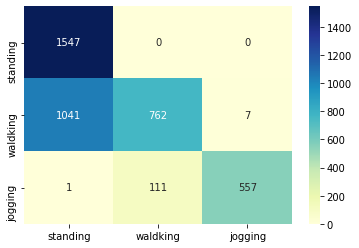

In [59]:
cm = confusion_matrix(y_train_clf, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [60]:
orig_train_acc = accuracy_score(y_train_clf, y_train_head)
orig_train_acc

0.711872826626925

#### test performance

In [61]:
y_test_head = svm_clf.predict(x_test_clf)

In [62]:
print(classification_report(y_test_clf, y_test_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.68      1.00      0.81       403
    waldking       0.77      0.34      0.47       387
     jogging       0.67      0.77      0.72       173

    accuracy                           0.69       963
   macro avg       0.71      0.71      0.67       963
weighted avg       0.72      0.69      0.66       963



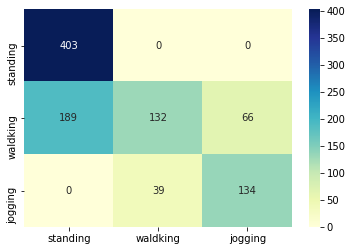

In [63]:
cm = confusion_matrix(y_test, y_test_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [64]:
orig_test_acc = accuracy_score(y_test_clf, y_test_head)
orig_test_acc

0.6947040498442367

In [65]:
####

In [66]:
x_train_activity, _ = filter_by_activity_index(x=x_train, y=y_train, activity_idx=0)

In [67]:
input_shape = x_train_activity[0].shape
latent_dim = 64
kernel_num = 3
kernel_size = 9
batch_size = 64
small = True

steps = 1000
batch_size = 32

In [68]:
#### No smoothing

In [69]:
label_smoothing = False

In [70]:
discriminator = create_discriminator(input_shape=input_shape)
generator = create_generator(latent_dim, kernel_num=kernel_num, kernel_size=kernel_size, small=small)
gan = create_gan(generator_model=generator, discriminator_model=discriminator)

train_gan(generator, discriminator, gan, x_train_activity, steps, label_smoothing=smooth_labels)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 246, 8)            128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 1968)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1969      
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________________
discriminator loss: [0.6590160727500916, 0.140625]
adversarial loss: 0.9057153463363647
discriminator loss: [0.6836721897125244, 0.109375]
adversarial loss: 0.8375258445739746
discriminator loss: [0.7284150123596191, 0.0]
adversarial loss: 0.7068513631820679
discriminator loss: [0.7015441060066223, 0.03125]
adversarial loss: 0.6762182116508484
discriminator loss: [0.6927961707115

In [71]:
random_latent_vectors = np.random.normal(size=(1000, latent_dim))
generated_sensor_data = generator.predict(random_latent_vectors)
    
gen_df = pd.DataFrame(generated_sensor_data.reshape(1000, 3, 250).tolist(), columns= ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'])
gen_df['userAcceleration.c'] = calc_consultant(gen_df)
gen_df['act'] = 0

gen_windowed_df = windowing_dataframe(gen_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
    
input_cols = ['userAcceleration.c']
x_gen, y_gen = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
    
x_gen = x_gen.reshape((len(x_gen), window_size))

In [72]:
add_sample_num = 1000
x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, np.zeros(add_sample_num)])

In [73]:
x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, np.zeros(add_sample_num)])
svm_clf = SVC()
svm_clf.fit(x_train_gen, y_train_gen)

SVC()

In [74]:
y_train_head = svm_clf.predict(x_train_clf)
train_acc = accuracy_score(y_train_clf, y_train_head)
print(orig_train_acc, ' vs ', train_acc)

0.711872826626925  vs  0.6716343765524093


In [75]:
y_test_head = svm_clf.predict(x_test_clf)
test_acc = accuracy_score(y_test_clf, y_test_head)
print(orig_test_acc, ' vs ', test_acc)

0.6947040498442367  vs  0.6708203530633438


/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans/utils/plotting.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=2, figsize=(10, 5))


<Figure size 432x288 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

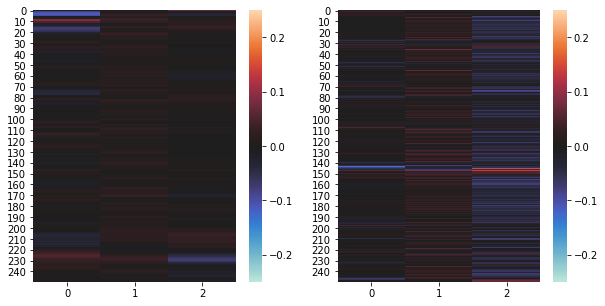

<Figure size 576x1440 with 0 Axes>

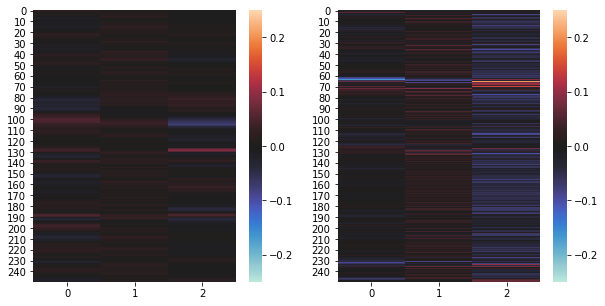

<Figure size 576x1440 with 0 Axes>

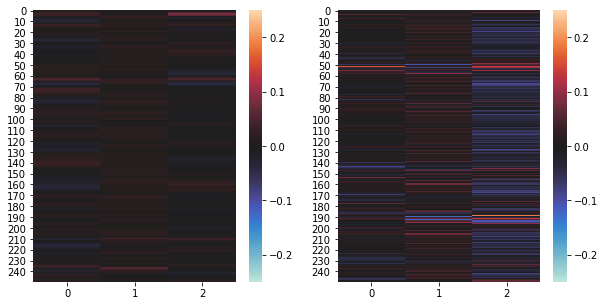

<Figure size 576x1440 with 0 Axes>

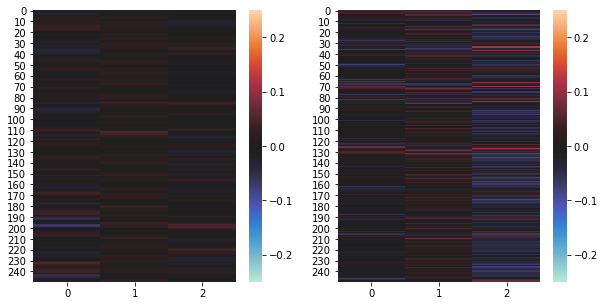

<Figure size 576x1440 with 0 Axes>

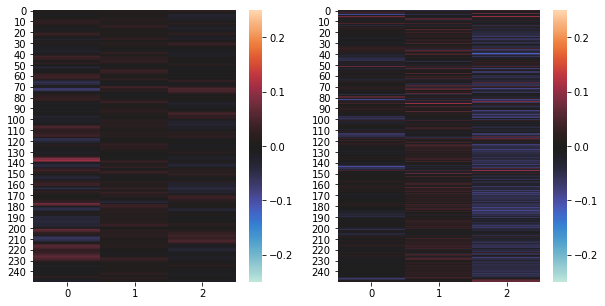

<Figure size 576x1440 with 0 Axes>

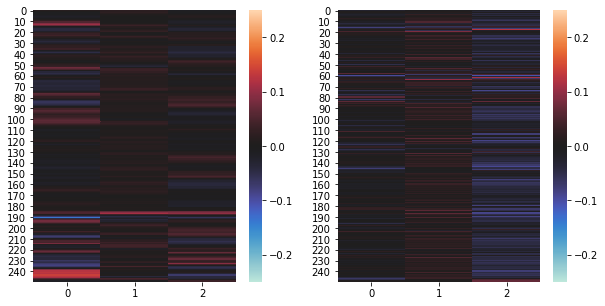

<Figure size 576x1440 with 0 Axes>

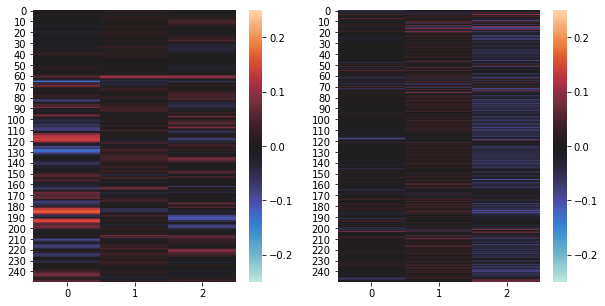

<Figure size 576x1440 with 0 Axes>

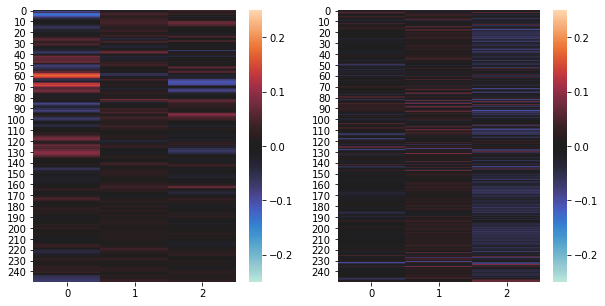

<Figure size 576x1440 with 0 Axes>

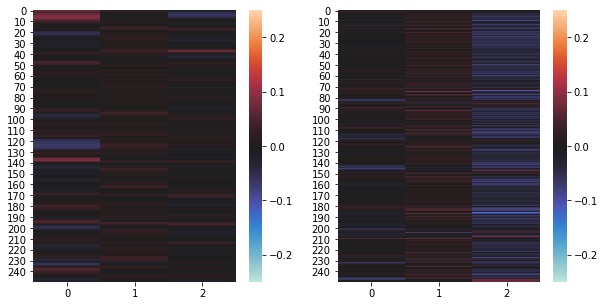

<Figure size 576x1440 with 0 Axes>

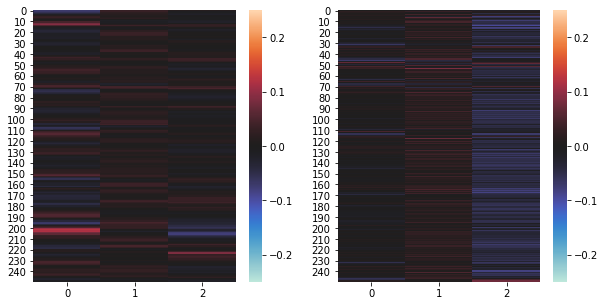

In [76]:
plot_n_heatmaps(x_train_activity, generated_sensor_data, n=10)

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans/utils/plotting.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=2, figsize=(10, 5), sharey=True)


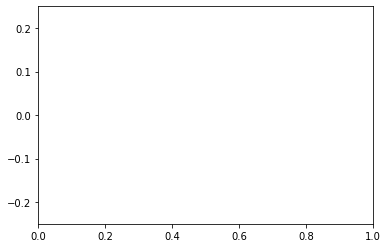

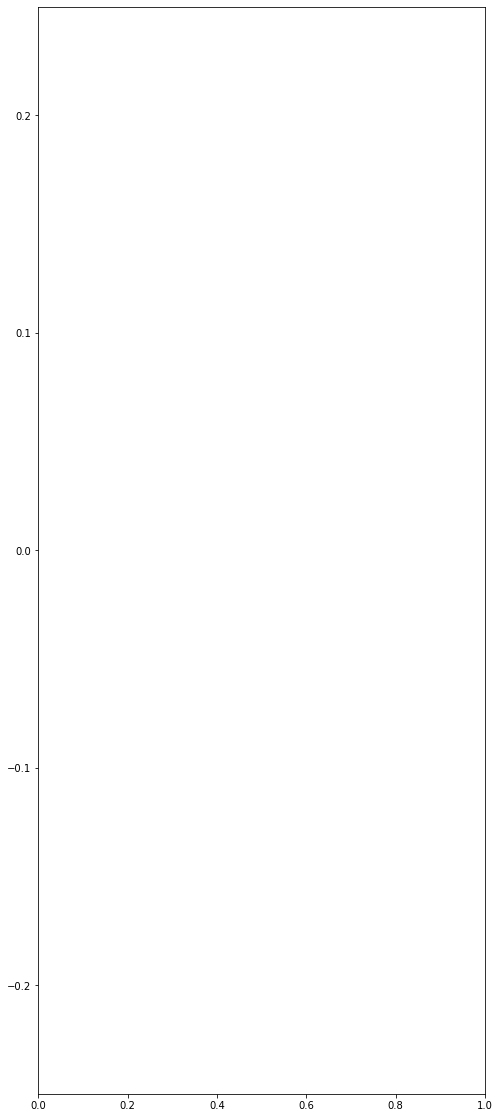

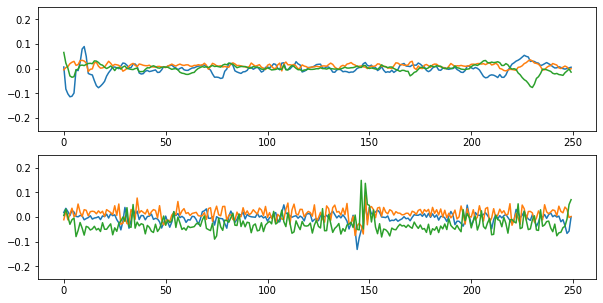

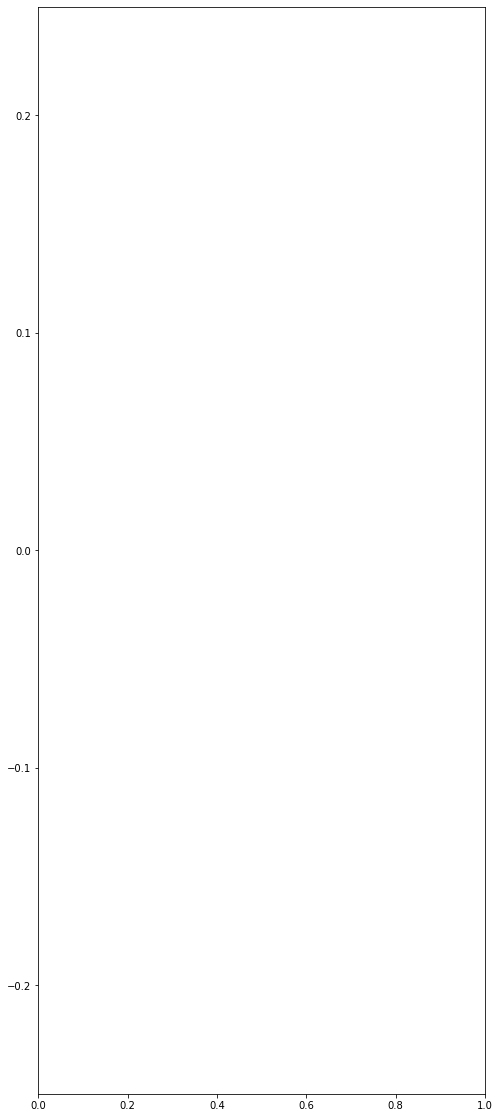

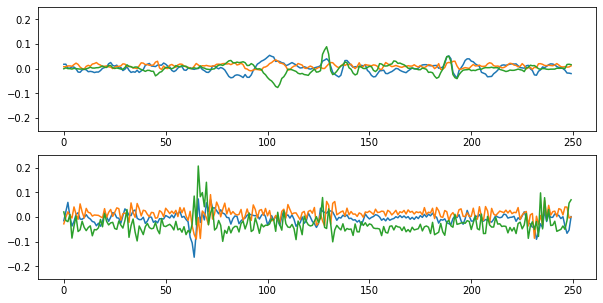

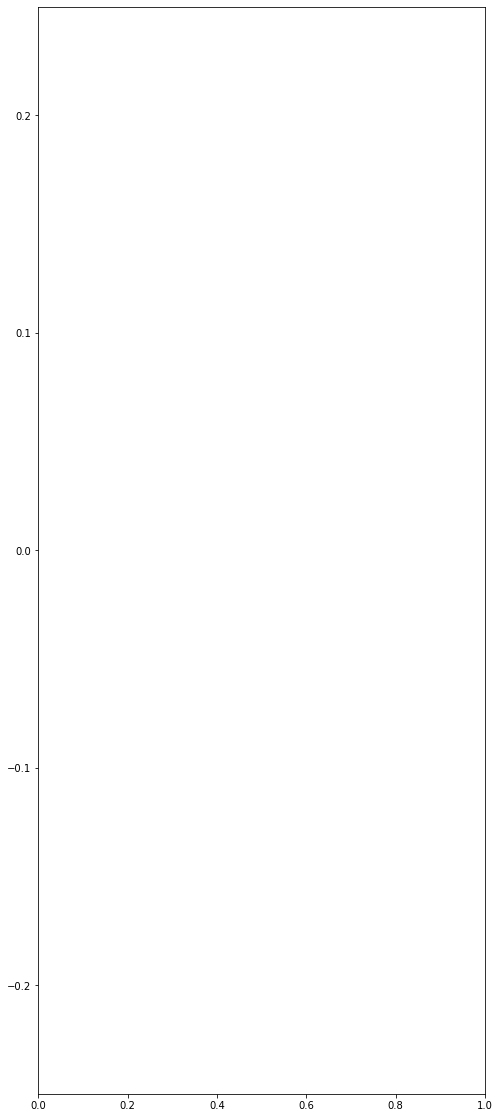

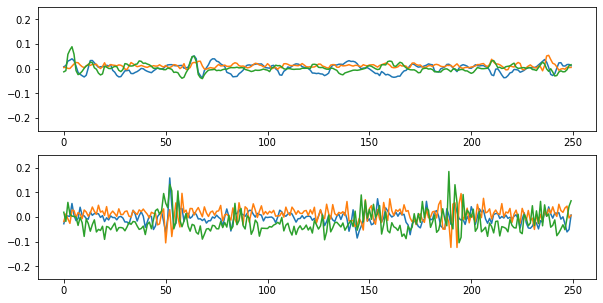

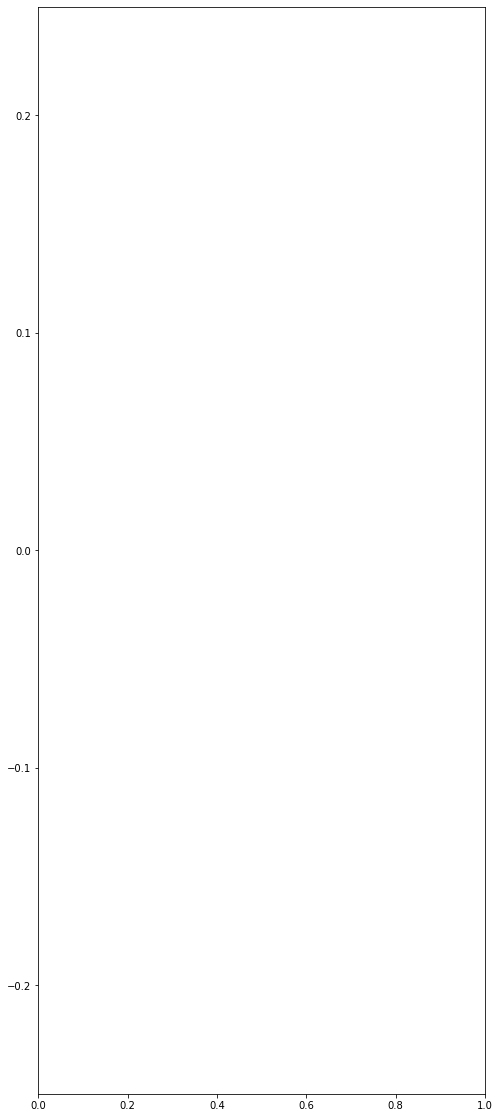

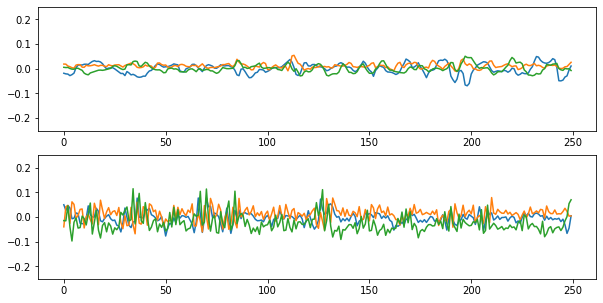

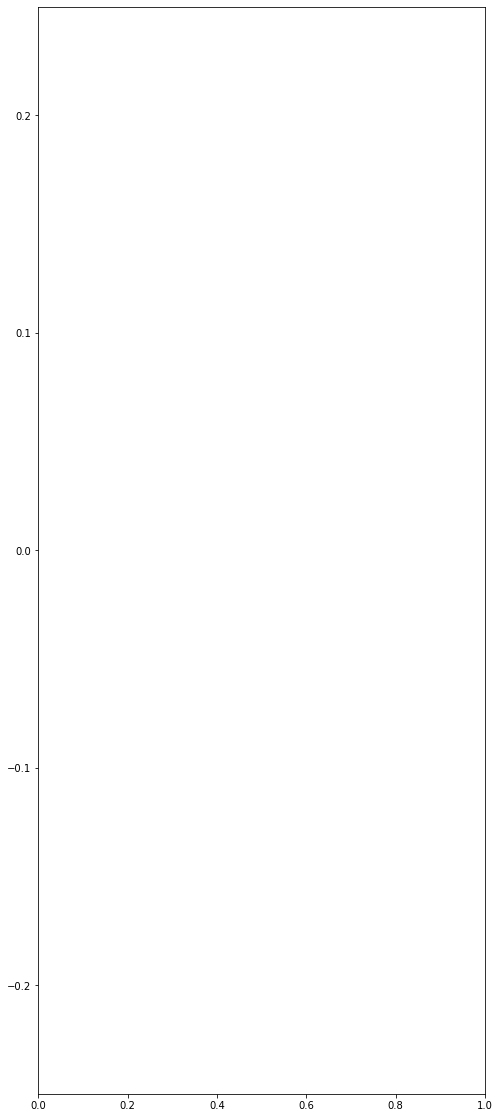

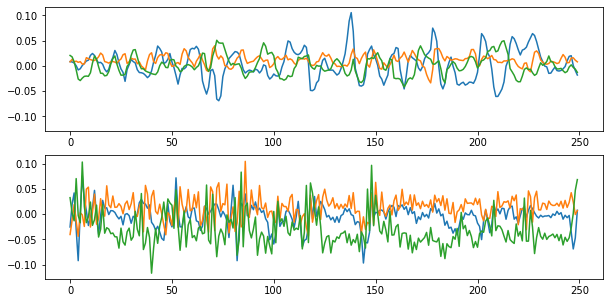

<Figure size 576x1440 with 0 Axes>

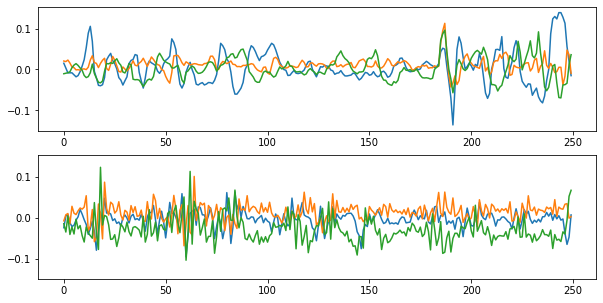

<Figure size 576x1440 with 0 Axes>

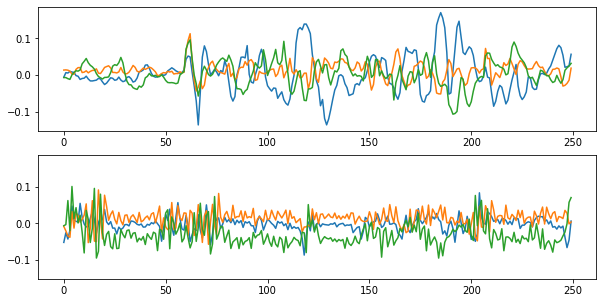

<Figure size 576x1440 with 0 Axes>

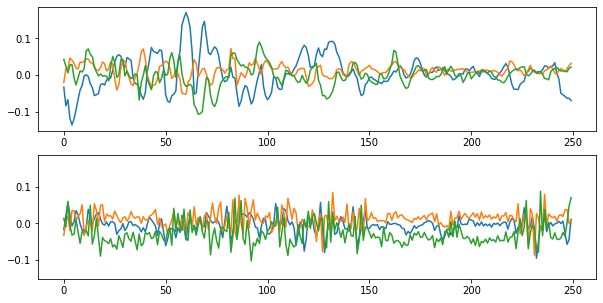

<Figure size 576x1440 with 0 Axes>

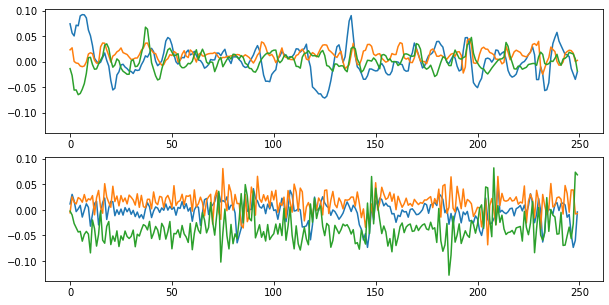

<Figure size 576x1440 with 0 Axes>

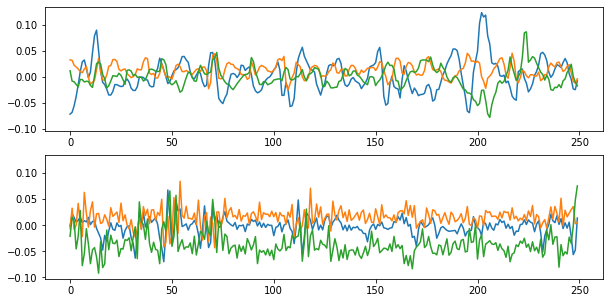

In [77]:
plot_n_lineplots(x_train_activity, generated_sensor_data, n=10)

In [78]:
## SMOOTHING

In [79]:
label_smoothing = True

In [80]:
discriminator = create_discriminator(input_shape=input_shape)
generator = create_generator(latent_dim, kernel_num=kernel_num, kernel_size=kernel_size, small=small)
gan = create_gan(generator_model=generator, discriminator_model=discriminator)

train_gan(generator, discriminator, gan, x_train_activity, steps, label_smoothing=smooth_labels)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 246, 8)            128       
_________________________________________________________________
flatten_3 (Flatten)          (None, 1968)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1969      
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________________
discriminator loss: [0.621712327003479, 0.046875]
adversarial loss: 0.9813413619995117
discriminator loss: [0.7025997638702393, 0.046875]
adversarial loss: 0.8855862617492676
discriminator loss: [0.7224790453910828, 0.015625]
adversarial loss: 0.6852978467941284
discriminator loss: [0.7000370621681213, 0.078125]
adversarial loss: 0.6753593683242798
discriminator loss: [0.69555240

In [81]:
random_latent_vectors = np.random.normal(size=(1000, latent_dim))
generated_sensor_data = generator.predict(random_latent_vectors)
    
gen_df = pd.DataFrame(generated_sensor_data.reshape(1000, 3, 250).tolist(), columns= ['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z'])
gen_df['userAcceleration.c'] = calc_consultant(gen_df)
gen_df['act'] = 0
    
gen_windowed_df = windowing_dataframe(gen_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
    
input_cols = ['userAcceleration.c']
x_gen, y_gen = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
    
x_gen = x_gen.reshape((len(x_gen), window_size))

In [82]:
add_sample_num = 500
x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, np.zeros(add_sample_num)])

In [83]:
x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, np.zeros(add_sample_num)])
svm_clf = SVC()
svm_clf.fit(x_train_gen, y_train_gen)

SVC()

In [84]:
y_train_head = svm_clf.predict(x_train_clf)
train_acc = accuracy_score(y_train_clf, y_train_head)
print(orig_train_acc, ' vs ', train_acc)

0.711872826626925  vs  0.6828117237953304


In [85]:
y_test_head = svm_clf.predict(x_test_clf)
test_acc = accuracy_score(y_test_clf, y_test_head)
print(orig_test_acc, ' vs ', test_acc)

0.6947040498442367  vs  0.67601246105919


/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans/utils/plotting.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(ncols=2, figsize=(10, 5))


<Figure size 432x288 with 0 Axes>

<Figure size 576x1440 with 0 Axes>

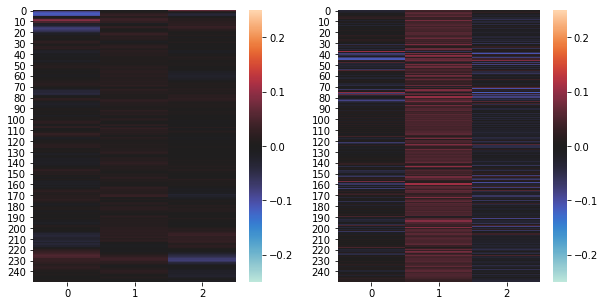

<Figure size 576x1440 with 0 Axes>

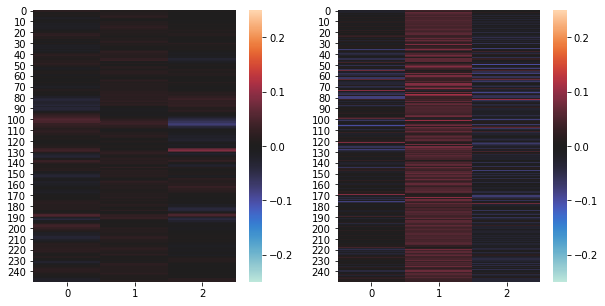

<Figure size 576x1440 with 0 Axes>

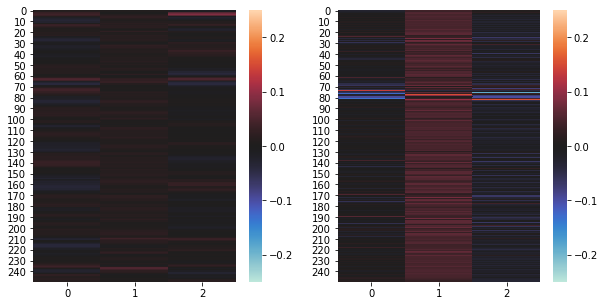

<Figure size 576x1440 with 0 Axes>

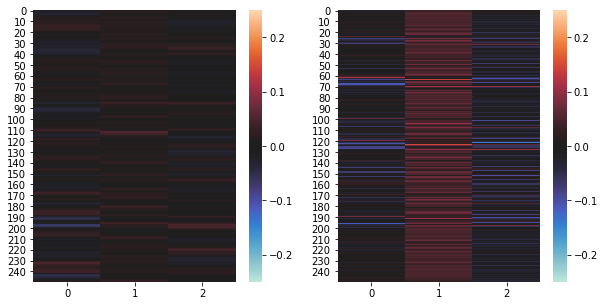

<Figure size 576x1440 with 0 Axes>

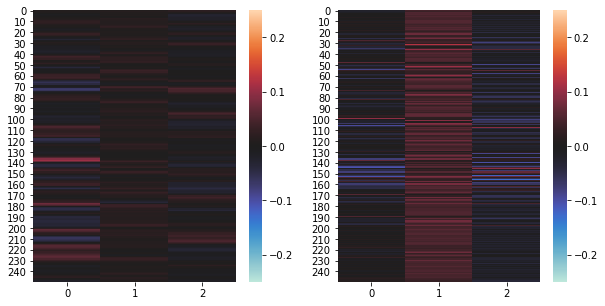

<Figure size 576x1440 with 0 Axes>

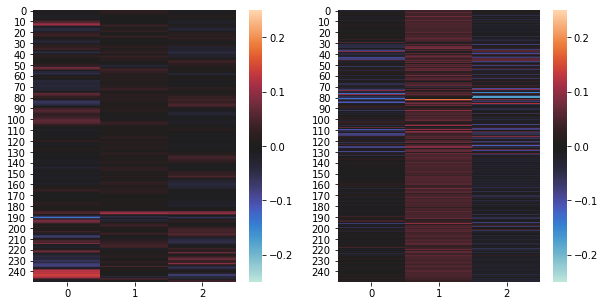

<Figure size 576x1440 with 0 Axes>

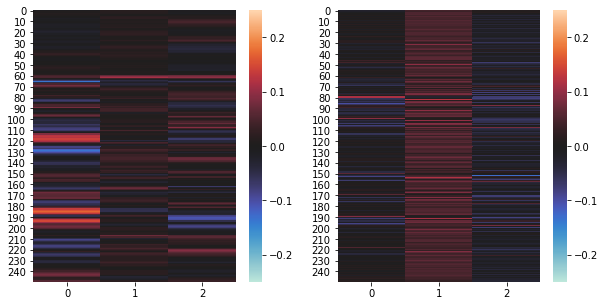

<Figure size 576x1440 with 0 Axes>

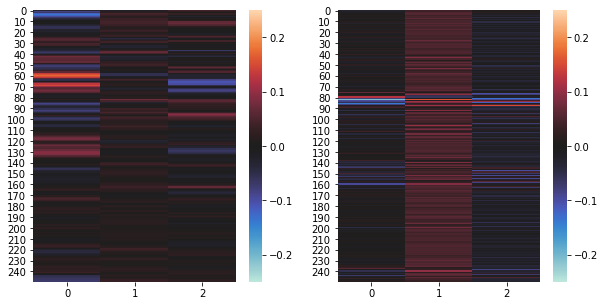

<Figure size 576x1440 with 0 Axes>

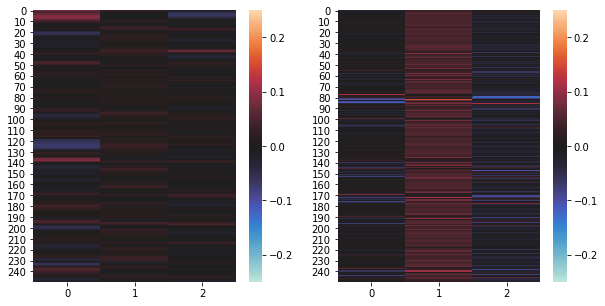

<Figure size 576x1440 with 0 Axes>

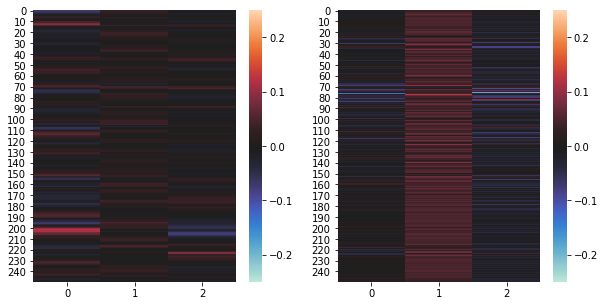

In [86]:
plot_n_heatmaps(x_train_activity, generated_sensor_data, n=10, save_dir='out/smooothing_steps-{}_latentdim-{}_kernelnum-{}_kernelsize-{}_small-{}'.format(steps, latent_dim, kernel_num, kernel_size, small))

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans/utils/plotting.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=2, figsize=(10, 5), sharey=True)


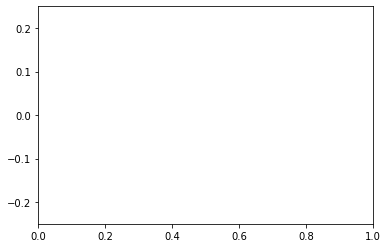

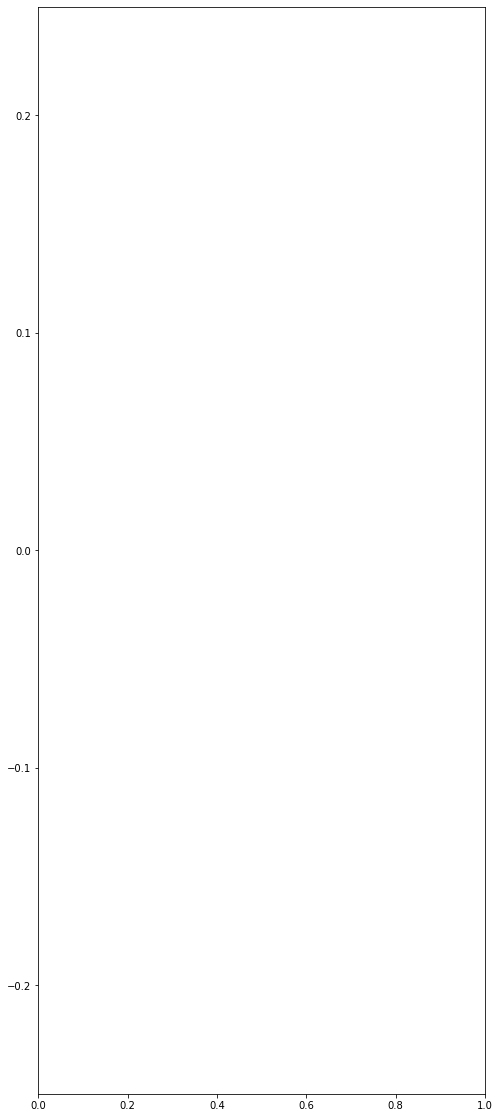

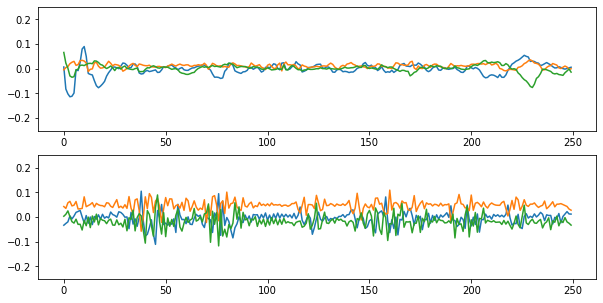

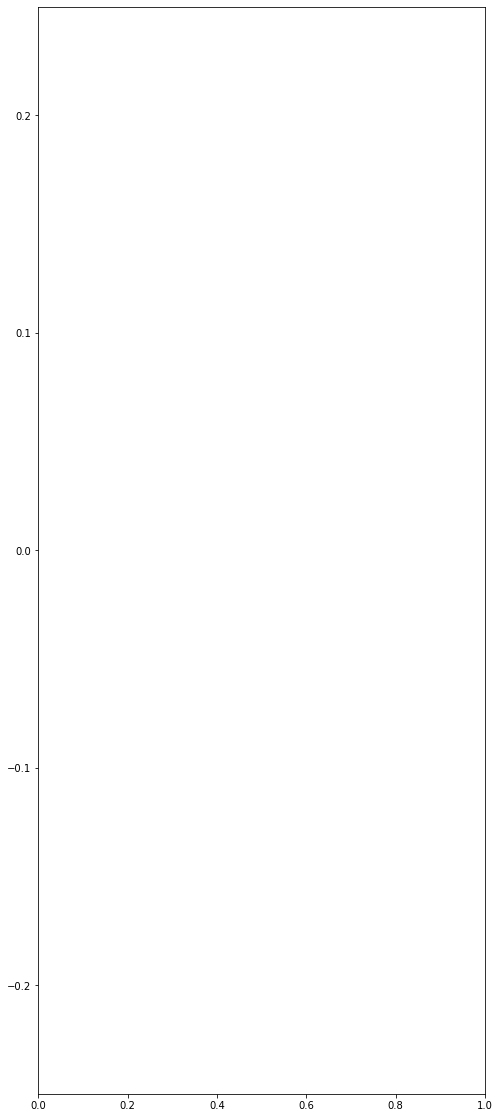

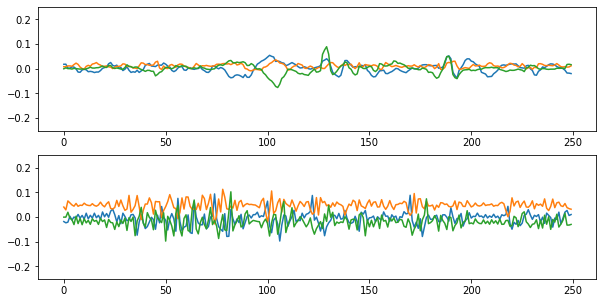

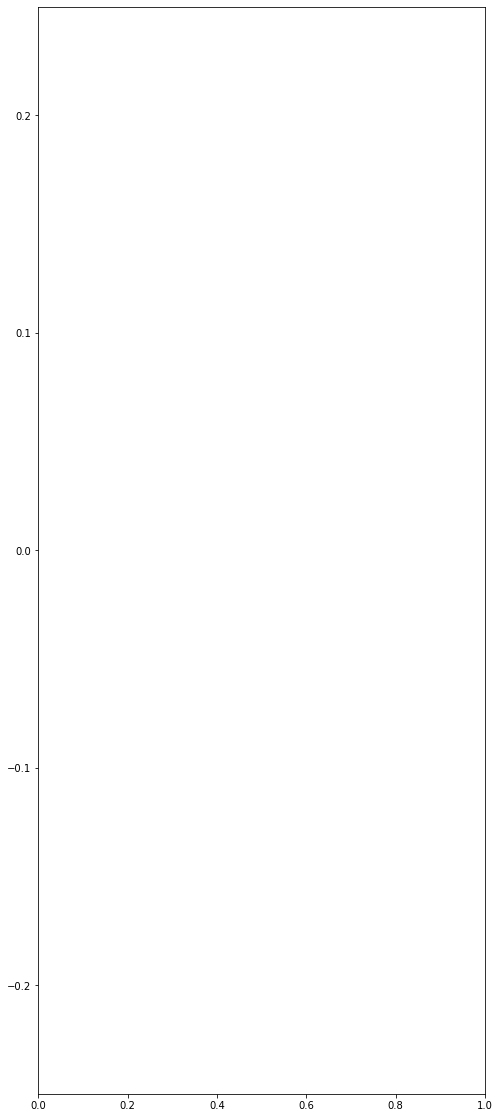

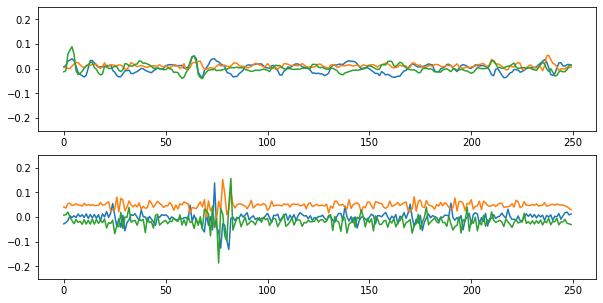

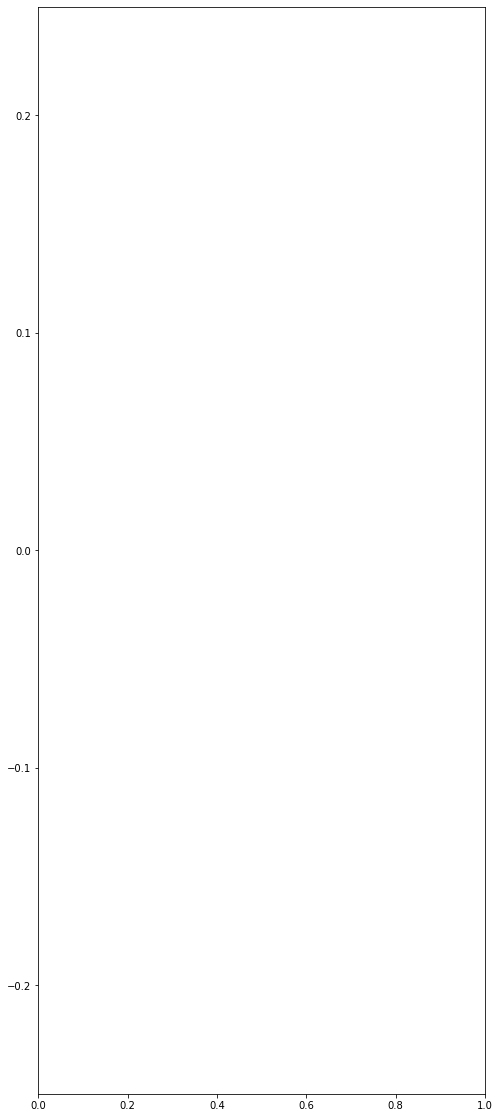

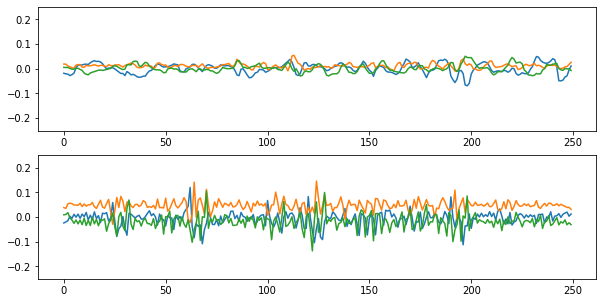

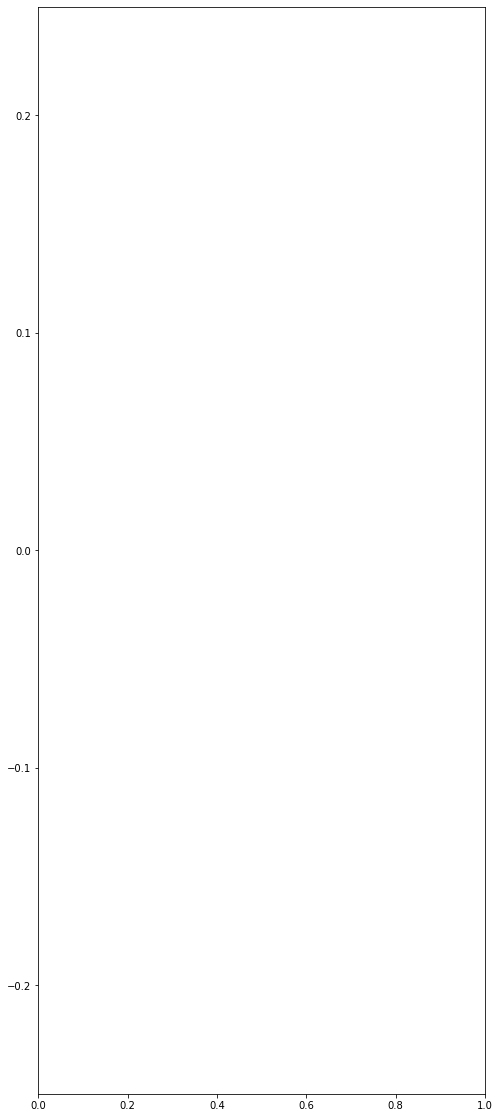

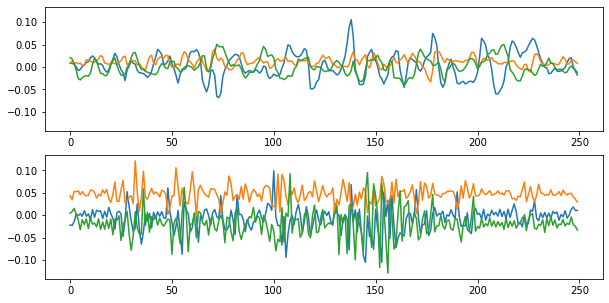

<Figure size 576x1440 with 0 Axes>

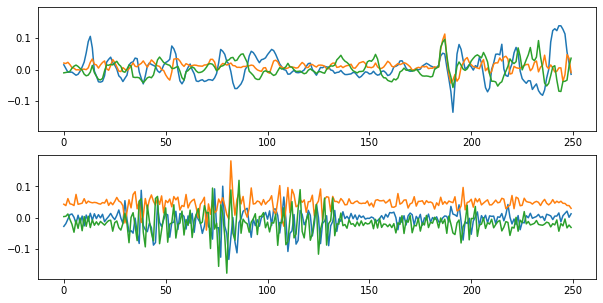

<Figure size 576x1440 with 0 Axes>

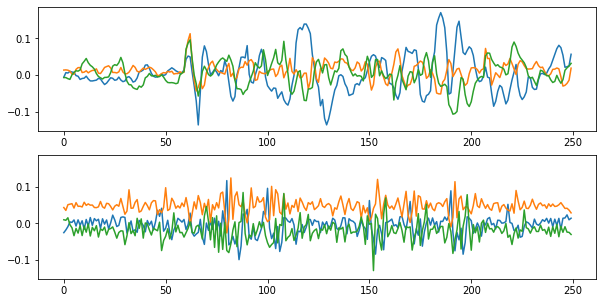

<Figure size 576x1440 with 0 Axes>

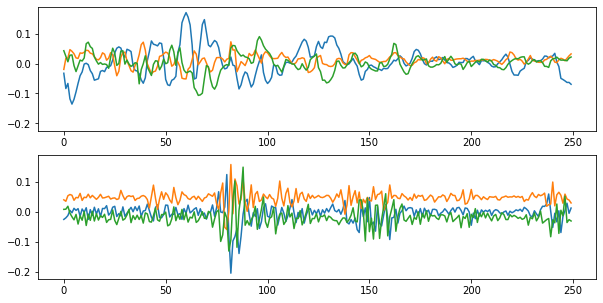

<Figure size 576x1440 with 0 Axes>

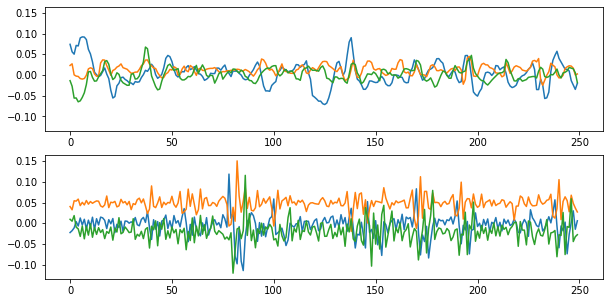

<Figure size 576x1440 with 0 Axes>

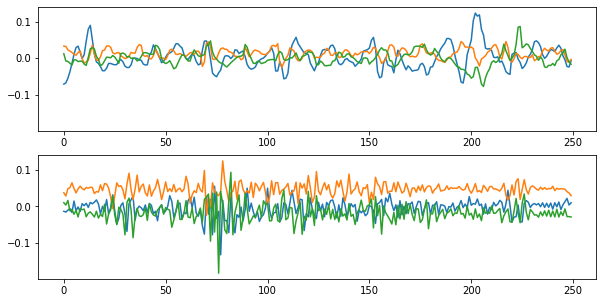

In [87]:
plot_n_lineplots(x_train_activity, generated_sensor_data, n=10, save_dir='out/smooothing_steps-{}_latentdim-{}_kernelnum-{}_kernelsize-{}_small-{}'.format(steps, latent_dim, kernel_num, kernel_size, small))